Developing a model to determine anamolies within a dataset 

Step 1: Importing my libraries

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Step 2: Data Collection

I am using the hfs.raw.1.csv file from the game TimeSpy to test my model

In [16]:
df = pd.read_csv('ABN_AlanWake2_2.results.0.dx12-2160p-ultra-NewGameGameplay_._test_wishGranted.csv')
df.head()

,timestamp,hw.md.RenderBasic.SYSMEM_TRANSACTION_READ,hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE,hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ,hw.raw.RenderBasic.GPU_TIME,hw.gpu.symbols.GpuTimestampFrequency,hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE,hw.gal.d_gpu_busy,...,hw.gal.gtlimit_ineff_op,hw.gal.gtlimit_psys_crit,hw.gal.d_pkg_joules,hw.gal.d_pkg_temp,hw.gal.rc6_res,hw.gal.pg_req,hw.gal.pg_status,hw.gal.ia_pstate_limit,hw.md.RenderBasic.GPU_MEMORY_BYTE_READ_RATE,hw.md.RenderBasic.GPU_MEMORY_BYTE_WRITE_RATE
0,107529,0.000000e+00,0.00000,0.000000,0.00000,0.00,0.00,19200000,0.000000e+00,926052685,...,0,0,2170157073,46,1073459729,0,0,255,0.000000,0.000000
1,215837,2.125586e+06,874395.24320,10784.060270,283413.96760,75794428.85,19230786.28,19200000,3.594943e+08,926065435,...,0,0,2170262796,46,1073494877,40,2,255,0.151346,0.717838
2,327283,2.136676e+06,716302.06560,2018.914990,29278.75384,85101170.07,19230838.25,19200000,1.888988e+07,926074898,...,0,0,2170298770,46,1073547329,40,0,255,0.169929,0.037719
3,436921,1.439282e+04,13207.09973,1276.929532,20157.24475,29074636.53,19230786.77,19200000,7.592805e+06,926085045,...,0,0,2170334098,45,1073620134,0,0,255,0.058056,0.015161
4,546731,2.322193e+03,11610.96439,1029.050178,15845.55141,20357244.33,19230771.33,19200000,3.211711e+06,926092187,...,0,0,2170370268,45,1073669465,40,2,255,0.040649,0.006413


Step 3: Data Cleaning/Preprocessing

feature engineering steps:

1. seeing the column names

2. determing what the unique values are in each column

3. If there are columns with the same value in each row, then dropping those rows because an isolation forest can not pick up on any variance in that regard.

4. looking at some statistical values per column (.describe())

5. make histograms to see where there could be outliers

In [17]:
print(df.columns)

Index(['timestamp', 'hw.md.RenderBasic.SYSMEM_TRANSACTION_READ',
       'hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE',
       'hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ',
       'hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE',
       'hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ',
       'hw.raw.RenderBasic.GPU_TIME', 'hw.gpu.symbols.GpuTimestampFrequency',
       'hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE', 'hw.gal.d_gpu_busy',
       'hw.gal.d_gti_busy', 'hw.gal.d_crystal_clock',
       'hw.gal.d_gpu_sq_fifo_full', 'hw.gal.d_gpu_sq_fifo_stalled',
       'hw.gal.d_gpu_ticks', 'hw.gal.d_unslice_freq_req',
       'hw.gal.d_slice_freq_req', 'hw.gal.d_unslice_freq',
       'hw.gal.d_slice_freq', 'hw.gal.ia_freq', 'hw.gal.ring_freq',
       'hw.gal.qclk_ratio', 'hw.gal.qclk_base', 'hw.gal.gt_perf_limit',
       'hw.gal.gtlimit_prochot', 'hw.gal.gtlimit_thermal',
       'hw.gal.gtlimit_ratl', 'hw.gal.gtlimit_vr_thermalert',
       'hw.gal.gtlimit_vr_tdc', 'hw.gal.gtlimit_other',
     

In [18]:
def check_unique_one(df):
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 1:
            print(f"{column}")
check_unique_one(df)

hw.gpu.symbols.GpuTimestampFrequency
hw.gal.d_crystal_clock
hw.gal.d_slice_freq
hw.gal.ring_freq
hw.gal.qclk_ratio
hw.gal.qclk_base
hw.gal.gtlimit_prochot
hw.gal.gtlimit_ratl
hw.gal.gtlimit_vr_thermalert
hw.gal.gtlimit_vr_tdc
hw.gal.gtlimit_other
hw.gal.gtlimit_max_vid
hw.gal.gtlimit_pbm_pl1
hw.gal.gtlimit_ineff_op
hw.gal.gtlimit_psys_crit
hw.gal.ia_pstate_limit


In [19]:
df_cleaned = df.drop(columns = {'hw.gpu.symbols.GpuTimestampFrequency', 'hw.gal.d_crystal_clock', 'hw.gal.d_slice_freq', 'hw.gal.ring_freq', 'hw.gal.qclk_ratio', 'hw.gal.qclk_base', 'hw.gal.gtlimit_prochot','hw.gal.gtlimit_ratl','hw.gal.gtlimit_vr_thermalert','hw.gal.gtlimit_vr_tdc','hw.gal.gtlimit_other','hw.gal.gtlimit_max_vid','hw.gal.gtlimit_pbm_pl1','hw.gal.gtlimit_ineff_op','hw.gal.gtlimit_psys_crit','hw.gal.ia_pstate_limit'})
df_cleaned.head()

,timestamp,hw.md.RenderBasic.SYSMEM_TRANSACTION_READ,hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE,hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ,hw.raw.RenderBasic.GPU_TIME,hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE,hw.gal.d_gpu_busy,hw.gal.d_gti_busy,...,hw.gal.gt_perf_limit,hw.gal.gtlimit_thermal,hw.gal.gtlimit_pbm_pl2,hw.gal.d_pkg_joules,hw.gal.d_pkg_temp,hw.gal.rc6_res,hw.gal.pg_req,hw.gal.pg_status,hw.md.RenderBasic.GPU_MEMORY_BYTE_READ_RATE,hw.md.RenderBasic.GPU_MEMORY_BYTE_WRITE_RATE
0,107529,0.000000e+00,0.00000,0.000000,0.00000,0.00,0.00,0.000000e+00,926052685,0,...,134610946,1,0,2170157073,46,1073459729,0,0,0.000000,0.000000
1,215837,2.125586e+06,874395.24320,10784.060270,283413.96760,75794428.85,19230786.28,3.594943e+08,926065435,96585584,...,134610944,0,0,2170262796,46,1073494877,40,2,0.151346,0.717838
2,327283,2.136676e+06,716302.06560,2018.914990,29278.75384,85101170.07,19230838.25,1.888988e+07,926074898,0,...,134610944,0,0,2170298770,46,1073547329,40,0,0.169929,0.037719
3,436921,1.439282e+04,13207.09973,1276.929532,20157.24475,29074636.53,19230786.77,7.592805e+06,926085045,0,...,134610944,0,0,2170334098,45,1073620134,0,0,0.058056,0.015161
4,546731,2.322193e+03,11610.96439,1029.050178,15845.55141,20357244.33,19230771.33,3.211711e+06,926092187,96608733,...,134610944,0,0,2170370268,45,1073669465,40,2,0.040649,0.006413


In [20]:
df_cleaned.describe()

,timestamp,hw.md.RenderBasic.SYSMEM_TRANSACTION_READ,hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE,hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ,hw.raw.RenderBasic.GPU_TIME,hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE,hw.gal.d_gpu_busy,hw.gal.d_gti_busy,...,hw.gal.gt_perf_limit,hw.gal.gtlimit_thermal,hw.gal.gtlimit_pbm_pl2,hw.gal.d_pkg_joules,hw.gal.d_pkg_temp,hw.gal.rc6_res,hw.gal.pg_req,hw.gal.pg_status,hw.md.RenderBasic.GPU_MEMORY_BYTE_READ_RATE,hw.md.RenderBasic.GPU_MEMORY_BYTE_WRITE_RATE
count,8.328000e+03,8.328000e+03,8.328000e+03,8328.000000,8.328000e+03,8.328000e+03,8.328000e+03,8.328000e+03,8.328000e+03,8.328000e+03,...,8.328000e+03,8328.000000,8328.000000,8.328000e+03,8328.000000,8.328000e+03,8328.000000,8328.000000,8328.000000,8328.000000
mean,4.575180e+08,1.262133e+05,1.389943e+06,3980.892443,2.009860e+06,5.804178e+09,1.922393e+07,1.952130e+09,1.053325e+09,4.750906e+07,...,1.346111e+08,0.078410,0.057157,2.408388e+09,47.602546,1.309624e+09,15.033622,0.683958,11.589717,3.897992
std,2.642253e+08,5.813734e+05,6.085255e+06,5052.678039,2.737084e+06,1.532637e+10,3.649529e+05,4.351902e+09,9.920891e+07,6.625363e+07,...,4.754162e+02,0.268832,0.232156,1.807636e+08,4.981947,1.231279e+08,19.374730,0.948802,30.603526,8.689828
min,1.075290e+05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.260527e+08,0.000000e+00,...,1.346109e+08,0.000000,0.000000,2.170157e+09,42.000000,1.073460e+09,0.000000,0.000000,0.000000,0.000000
25%,2.284356e+08,1.588265e+04,4.672005e+03,1094.612313,2.398764e+04,6.399846e+07,1.923081e+07,1.464093e+07,9.726791e+08,0.000000e+00,...,1.346109e+08,0.000000,0.000000,2.267799e+09,46.000000,1.200532e+09,0.000000,0.000000,0.127792,0.029235
50%,4.570632e+08,2.839276e+04,1.333711e+04,2800.373162,9.421580e+04,1.655603e+08,1.923086e+07,1.135232e+08,1.022475e+09,0.000000e+00,...,1.346109e+08,0.000000,0.000000,2.349453e+09,46.000000,1.330531e+09,0.000000,0.000000,0.330589,0.226681
75%,6.868717e+08,5.805760e+04,3.164536e+04,3940.111218,4.425520e+06,7.048778e+08,1.923090e+07,8.229158e+08,1.149721e+09,1.300910e+08,...,1.346109e+08,0.000000,0.000000,2.576253e+09,46.000000,1.404761e+09,40.000000,2.000000,1.407491,1.643194
max,9.144376e+08,1.102469e+07,5.014328e+07,137623.519400,4.746171e+07,6.392164e+10,1.923161e+07,1.642958e+10,1.228982e+09,1.705560e+08,...,1.346130e+08,1.000000,1.000000,2.741008e+09,64.000000,1.514869e+09,40.000000,2.000000,127.637682,32.806399


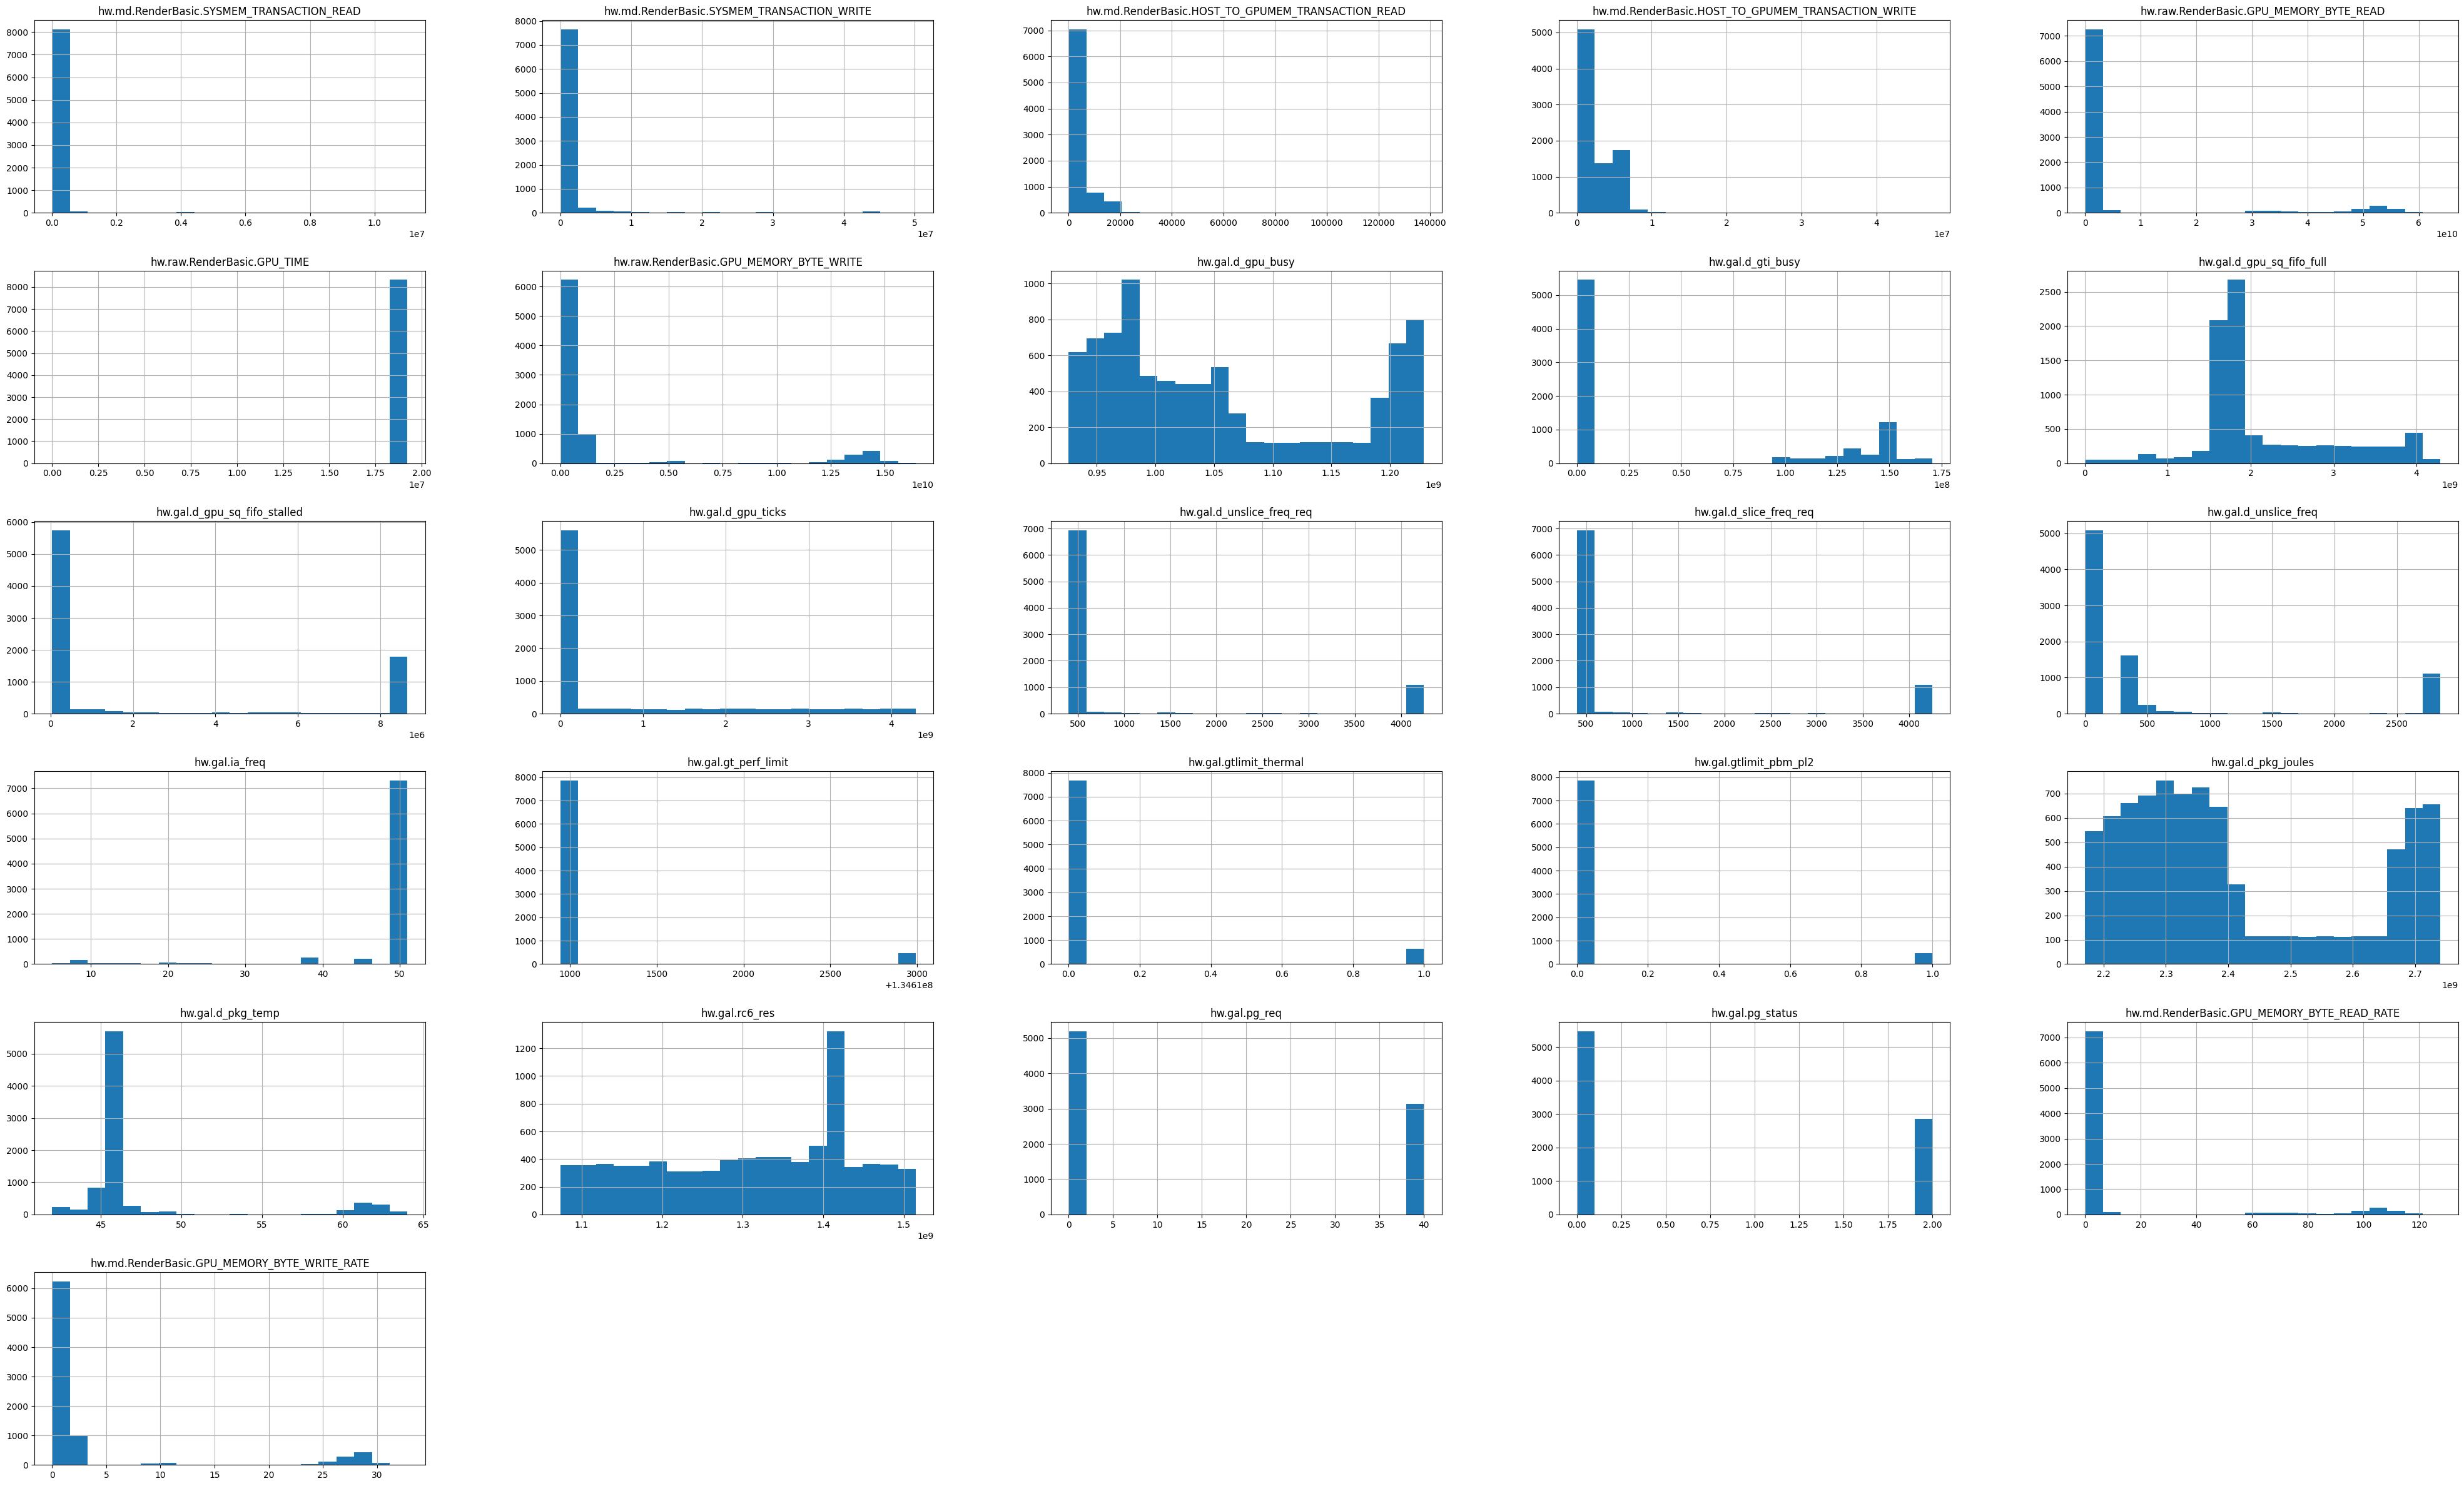

In [21]:
sample_z_score = df_cleaned.drop(columns='timestamp')
sample_z_score.hist(bins = 20, figsize =(50, 30))
plt.show()

In [22]:
#if they have two unique values, I'll drop because they are basically identifiers
def check_unique_two(df):
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 2:
            print(f"{column}")
check_unique_two(df)

hw.gal.gtlimit_thermal
hw.gal.gtlimit_pbm_pl2
hw.gal.pg_req
hw.gal.pg_status


In [24]:
df_cleaned.drop(columns = {'hw.gal.gtlimit_thermal','hw.gal.gtlimit_pbm_pl2','hw.gal.pg_req','hw.gal.pg_status'})

,timestamp,hw.md.RenderBasic.SYSMEM_TRANSACTION_READ,hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE,hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ,hw.raw.RenderBasic.GPU_TIME,hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE,hw.gal.d_gpu_busy,hw.gal.d_gti_busy,...,hw.gal.d_unslice_freq_req,hw.gal.d_slice_freq_req,hw.gal.d_unslice_freq,hw.gal.ia_freq,hw.gal.gt_perf_limit,hw.gal.d_pkg_joules,hw.gal.d_pkg_temp,hw.gal.rc6_res,hw.md.RenderBasic.GPU_MEMORY_BYTE_READ_RATE,hw.md.RenderBasic.GPU_MEMORY_BYTE_WRITE_RATE
0,107529,0.000000e+00,0.00000,0.000000,0.00000,0.000000e+00,0.00,0.000000e+00,926052685,0,...,400,400,0,49,134610946,2170157073,46,1073459729,0.000000,0.000000
1,215837,2.125586e+06,874395.24320,10784.060270,283413.96760,7.579443e+07,19230786.28,3.594943e+08,926065435,96585584,...,400,400,400,49,134610944,2170262796,46,1073494877,0.151346,0.717838
2,327283,2.136676e+06,716302.06560,2018.914990,29278.75384,8.510117e+07,19230838.25,1.888988e+07,926074898,0,...,400,400,400,49,134610944,2170298770,46,1073547329,0.169929,0.037719
3,436921,1.439282e+04,13207.09973,1276.929532,20157.24475,2.907464e+07,19230786.77,7.592805e+06,926085045,0,...,400,400,0,49,134610944,2170334098,45,1073620134,0.058056,0.015161
4,546731,2.322193e+03,11610.96439,1029.050178,15845.55141,2.035724e+07,19230771.33,3.211711e+06,926092187,96608733,...,400,400,400,49,134610944,2170370268,45,1073669465,0.040649,0.006413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8323,914003368,3.186560e+04,42261.14562,6688.748406,57519.56620,9.120311e+07,19230830.63,1.291368e+07,1228880510,0,...,400,400,0,49,134610944,2740863176,46,1514619662,0.182114,0.025786
8324,914112872,3.363347e+04,44190.16657,6620.762712,62993.13267,8.183884e+07,19230913.94,1.157298e+07,1228906911,170556021,...,400,400,400,50,134610944,2740900145,46,1514681784,0.163415,0.023109
8325,914220453,3.309135e+04,42079.92118,6320.818732,61813.88907,7.075114e+07,19230877.20,1.178625e+07,1228927133,0,...,400,400,0,49,134610944,2740934714,46,1514748437,0.141275,0.023535
8326,914330390,3.253682e+04,40896.14961,7749.893121,62772.31505,8.280481e+07,19230859.49,1.110465e+07,1228950991,0,...,400,400,0,49,134610944,2740971204,46,1514813200,0.165344,0.022174


Step 4: The Model

In [25]:
#generally getting in the 1500-1700 range for the number of outliers 
sample_isf = df_cleaned.drop(columns='timestamp')
# Train the model
isf = IsolationForest()
isf.fit(sample_isf)
# Predictions
predictions = isf.predict(sample_isf)
# Extract scores
sample_isf["iso_forest_scores"] = isf.decision_function(sample_isf)
# Extract predictions
sample_isf["iso_forest_outliers"] = predictions
# Replace "-1" with "Yes" and "1" with "No"
sample_isf['iso_forest_outliers'] = sample_isf['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
sample_isf.head()


,hw.md.RenderBasic.SYSMEM_TRANSACTION_READ,hw.md.RenderBasic.SYSMEM_TRANSACTION_WRITE,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_READ,hw.md.RenderBasic.HOST_TO_GPUMEM_TRANSACTION_WRITE,hw.raw.RenderBasic.GPU_MEMORY_BYTE_READ,hw.raw.RenderBasic.GPU_TIME,hw.raw.RenderBasic.GPU_MEMORY_BYTE_WRITE,hw.gal.d_gpu_busy,hw.gal.d_gti_busy,hw.gal.d_gpu_sq_fifo_full,...,hw.gal.gtlimit_pbm_pl2,hw.gal.d_pkg_joules,hw.gal.d_pkg_temp,hw.gal.rc6_res,hw.gal.pg_req,hw.gal.pg_status,hw.md.RenderBasic.GPU_MEMORY_BYTE_READ_RATE,hw.md.RenderBasic.GPU_MEMORY_BYTE_WRITE_RATE,iso_forest_scores,iso_forest_outliers
0,0.000000e+00,0.00000,0.000000,0.00000,0.00,0.00,0.000000e+00,926052685,0,1542974502,...,0,2170157073,46,1073459729,0,0,0.000000,0.000000,0.040235,No
1,2.125586e+06,874395.24320,10784.060270,283413.96760,75794428.85,19230786.28,3.594943e+08,926065435,96585584,1543032330,...,0,2170262796,46,1073494877,40,2,0.151346,0.717838,-0.062171,Yes
2,2.136676e+06,716302.06560,2018.914990,29278.75384,85101170.07,19230838.25,1.888988e+07,926074898,0,1543051026,...,0,2170298770,46,1073547329,40,0,0.169929,0.037719,-0.005063,Yes
3,1.439282e+04,13207.09973,1276.929532,20157.24475,29074636.53,19230786.77,7.592805e+06,926085045,0,1543070885,...,0,2170334098,45,1073620134,0,0,0.058056,0.015161,0.110790,No
4,2.322193e+03,11610.96439,1029.050178,15845.55141,20357244.33,19230771.33,3.211711e+06,926092187,96608733,1543080768,...,0,2170370268,45,1073669465,40,2,0.040649,0.006413,0.028653,No


In [26]:
sample_isf_2 = df_cleaned.drop(columns='timestamp')
# Standardize features
sample_scaled = StandardScaler().fit_transform(sample_isf_2)
# Define dimensions = 2
pca = PCA(n_components=2)
# Conduct the PCA
principal_comp = pca.fit_transform(sample_scaled)
# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
pca_df.head()
# Train the model
isf_2 = IsolationForest()
isf_2.fit(pca_df)
# Predictions
predictions = isf_2.predict(pca_df)
# Extract scores
pca_df["iso_forest_scores"] = isf_2.decision_function(pca_df)
# Extract predictions
pca_df["iso_forest_outliers"] = predictions
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])
# Print the first 5 firms
pca_df.head()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,-2.735630,-2.333579,-0.111136,Yes
1,0.237768,-2.713435,-0.106686,Yes
2,-1.437915,-2.266974,-0.053442,Yes
3,-2.368030,-2.017582,-0.011953,Yes
4,-0.612460,-2.625372,-0.087602,Yes


In [30]:
import plotly.express as px

# Function to plot firms on the 2-dimensional space
def plot_firms(dataframe, title, color=None):
    """ Plot firms on the 2-dimensional space """
    
    # Generate a scatter plot
    fig = px.scatter(dataframe, x="principal_component_1", y="principal_component_2", title=title, color=color)
    
    # Layout
    fig.update_layout(
        font_family='Arial Black',
        title=dict(font=dict(size=20, color='red')),
        yaxis=dict(tickfont=dict(size=13, color='black'),
                   title=dict(font=dict(size=15, color='black'))),
        xaxis=dict(tickfont=dict(size=13, color='black'),
                   title=dict(font=dict(size=15, color='black'))),
        legend=dict(font=dict(size=10, color='black')),
        plot_bgcolor='white'
    )
      
    return fig

# Plot [1] All firms
plot_firms(pca_df, "Figure 1: All Firms").show()

In [31]:
# [2] Normal Firms vs. Outlier Firms
plot_firms(dataframe=pca_df, title="Figure 2: Normal Firms vs. Outlier Firms", color='iso_forest_outliers').show()